In [1]:
import numpy as np
from tensorflow import keras
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras.applications import MobileNetV2

/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ds = tf.keras.utils.image_dataset_from_directory(
    './data/raw/Garbage classification/Garbage classification',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 2527 files belonging to 6 classes.


In [3]:
ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [4]:
CLASS_NAMES = ds.class_names

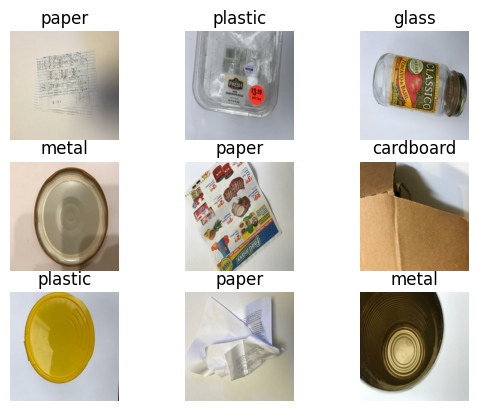

In [5]:
import matplotlib.pyplot as plt

for images, labels in ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

In [6]:
DATASET_SIZE = 2527 / 32

In [7]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

In [8]:
train_dataset = ds.take(train_size)
rem = ds.skip(train_size)
test_dataset = rem.take(test_size)
val_dataset = rem.skip(test_size)


In [9]:
len(list(test_dataset))

11

In [10]:
NUM_CLASSES = len(CLASS_NAMES)

In [11]:
BATCH_SIZE = 32

In [12]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [13]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
    classes=NUM_CLASSES
)

base_model.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = inputs

x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(NUM_CLASSES)(x)
model = keras.Model(inputs, outputs)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 8, 8, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 2265670 (8.64 MB)
Trainable params: 7686 (30.02

In [14]:

import sys
sys.path.insert(0, "../")
from mlflow_emissions_sdk.experiment_tracking_training import EmissionsTrackerMlflow

In [15]:
model.compile(
    optimizer=keras.optimizers.legacy.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

epochs = 1

tracker_info = {
    "tracking_uri": "http://127.0.0.1:5000",
    "experiment_name": "keras_test",
    "run_name": "keras_run",
    "flavor": "keras"
}

runner = EmissionsTrackerMlflow()
runner.read_params(tracker_info)

runner.start_training_job()

hist = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, batch_size=32)

runner.end_training_job()
runner.accuracy_per_emission(model, test_dataset)


[codecarbon INFO @ 17:29:36] [setup] RAM Tracking...
[codecarbon INFO @ 17:29:36] [setup] GPU Tracking...
[codecarbon INFO @ 17:29:36] No GPU found.
[codecarbon INFO @ 17:29:36] [setup] CPU Tracking...
[codecarbon WARNING @ 17:29:36] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon WARNING @ 17:29:36] We saw that you have a Apple M2 Pro but we don't know it. Please contact us.
[codecarbon INFO @ 17:29:36] CPU Model on constant consumption mode: Apple M2 Pro
[codecarbon INFO @ 17:29:36] >>> Tracker's metadata:
[codecarbon INFO @ 17:29:36]   Platform system: macOS-14.0-arm64-arm-64bit
[codecarbon INFO @ 17:29:36]   Python version: 3.11.6
[codecarbon INFO @ 17:29:36]   CodeCarbon version: 2.3.1
[codecarbon INFO @ 17:29:36]   Available RAM : 16.000 GB
[codecarbon INFO @ 17:29:36]   CPU count: 10
[codecarbon INFO @ 17:29:36]   CPU model: Apple M2 Pro
[codecarbon INFO @ 17:29:36]   GPU count: None
[codecarbon INFO @ 17:29:36]   GPU model: None
2023/10/23 17:29:39 WA

55/55 [==============================] - ETA: 0s - loss: 1.5820 - accuracy: 0.3972

[codecarbon INFO @ 17:29:54] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:29:54] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:29:54] 0.000202 kWh of electricity used since the beginning.


1/1 [==============================] - 0s 424ms/step
INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmpdp1fxpnm/model/data/model/assets


INFO:tensorflow:Assets written to: /var/folders/cr/fjzh9j6518vbwxjz621n0s7r0000gn/T/tmpdp1fxpnm/model/data/model/assets
[codecarbon INFO @ 17:30:09] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:30:09] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:30:09] 0.000404 kWh of electricity used since the beginning.
2023/10/23 17:30:17 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/Users/alial-gburi/rootsacademy/acad-proj/datar-mlflow-emissions/mlflow-emissions-sdk/venv/lib/python3.11/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
[codecarbon INFO @ 17:30:17] Energy consumed for RAM : 0.000064 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:30:17] Energy consumed for all CPUs : 0.000450 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:30:17] 0.000513 kWh of electricity used since the beginning.


11/11 [==============================] - 3s 191ms/step - loss: 1.1429 - accuracy: 0.6136
